In [7]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from mordred import Calculator, descriptors, GeometricalIndex, TopologicalIndex 
from rdkit.Chem import Descriptors
from IPython.display import display
# sklearn and models for model training 
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# For fine tuning
from sklearn.model_selection import GridSearchCV

In [ ]:
path_data = Path("../Data/cleaned_data.xlsx")
dataset = pd.read_excel(path_data)
inital_shape = dataset.shape
print(inital_shape)

In [1]:
# Define a function to check if a SMILES contains only carbon
def contains_carbon(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetSymbol() != "C":
                return False
        return True
    except:
        return False

In [13]:
carbon_dataset = dataset[dataset['smiles'].apply(contains_carbon)]
carbon_dataset.shape

(866, 2)

In [14]:
# Counting the number of carbon for every molecule and add this number in a new column

# Function to count the number of carbon atoms in a molecule
def count_carbon(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    carbon_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6)
    return carbon_count

# Add a new column 'carbon_count' to the DataFrame
carbon_dataset['carbon_count'] = carbon_dataset['smiles'].apply(count_carbon)

/var/folders/qy/8nbc5kyd0fd_60v_krw9dwf40000gp/T/ipykernel_2803/1337822114.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_dataset['carbon_count'] = carbon_dataset['smiles'].apply(count_carbon)


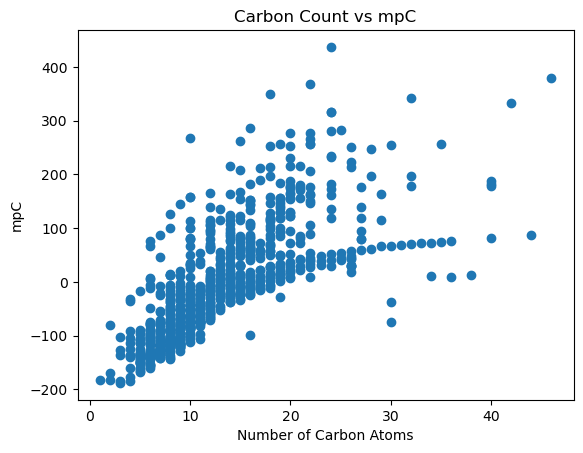

In [15]:
# Plot mpC vs Carbon_count

# Plotting
plt.scatter(carbon_dataset['carbon_count'], carbon_dataset['mpC'])
plt.xlabel('Number of Carbon Atoms')
plt.ylabel('mpC')
plt.title('Carbon Count vs mpC')
plt.show()

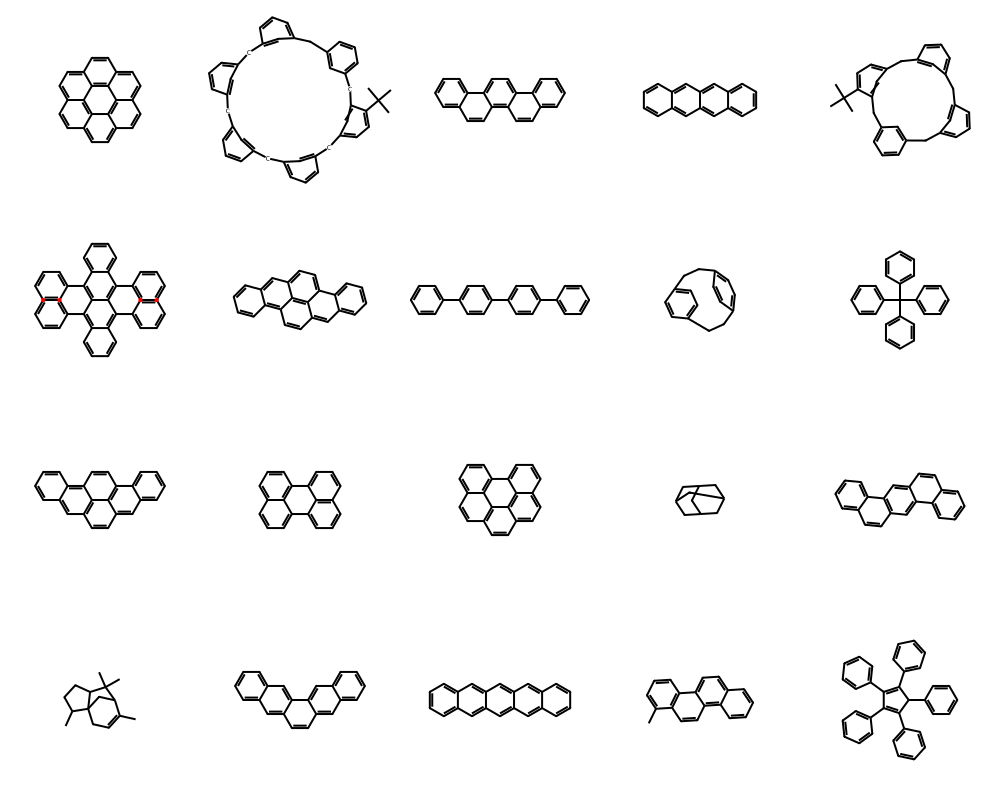

In [25]:
# See wich molecules have a high melting point

number_of_molecules_to_display = 20

# Sort the DataFrame by 'mpC' column in descending order
df_sorted = carbon_dataset.sort_values(by='mpC', ascending=False)

# Get the top 5 molecules
top_molecules = df_sorted.head(number_of_molecules_to_display)

# Generate RDKit Mol objects for the SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in top_molecules['smiles']]

# Draw the molecules in a grid
imge = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))

# Display the image
display(imge)

In [26]:
# See if we remove molecules with substructure benzene

# Function to check for benzene substructure
def has_benzene_substructure(smiles):
    mol = Chem.MolFromSmiles(smiles)
    benzene_substructure = Chem.MolFromSmarts('c1ccccc1')
    return mol.HasSubstructMatch(benzene_substructure)

# Add a new column 'num_aromatic_rings' to the DataFrame
carbon_dataset['has_benzene_sub'] = carbon_dataset['smiles'].apply(has_benzene_substructure)


/var/folders/qy/8nbc5kyd0fd_60v_krw9dwf40000gp/T/ipykernel_2803/4094466501.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_dataset['has_benzene_sub'] = carbon_dataset['smiles'].apply(has_benzene_substructure)


In [27]:
dataset_no_benzene = carbon_dataset[carbon_dataset['has_benzene_sub'] != True]

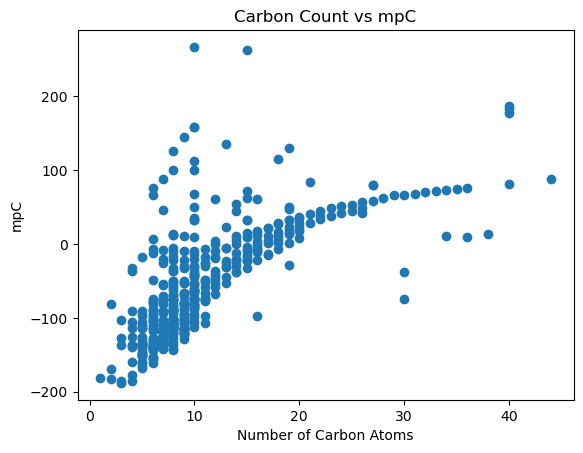

In [28]:
# See the plot without benzene 

# Plotting
plt.scatter(dataset_no_benzene['carbon_count'], dataset_no_benzene['mpC'])
plt.xlabel('Number of Carbon Atoms')
plt.ylabel('mpC')
plt.title('Carbon Count vs mpC')
plt.show()

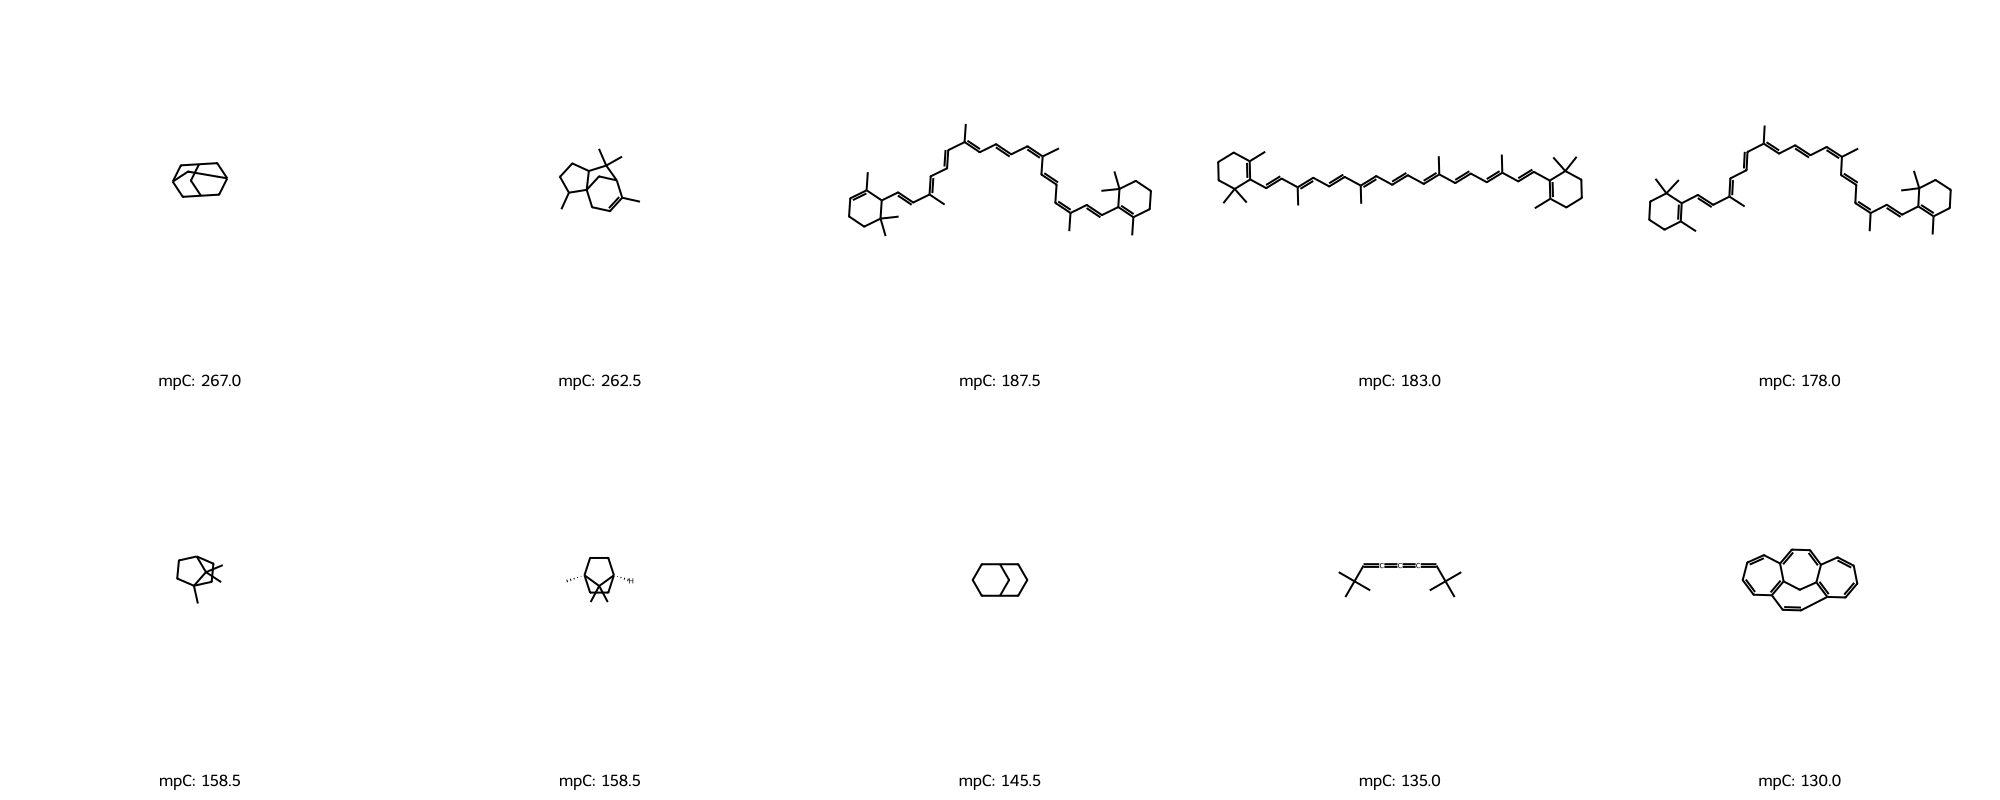

In [29]:
# Number of molecules to display
number_of_molecules_to_display = 10

# Sort the DataFrame by 'mpC' column in descending order
df_sorted = dataset_no_benzene.sort_values(by='mpC', ascending=False)

# Get the top molecules
top_molecules = df_sorted.head(number_of_molecules_to_display)

# Generate RDKit Mol objects for the SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in top_molecules['smiles']]

# Create legend text with melting point values
legend_texts = [f"mpC: {mp}" for mp in top_molecules['mpC']]

# Draw the molecules in a grid with legend
img = Draw.MolsToGridImage(mols, legends=legend_texts, molsPerRow=5, subImgSize=(400, 400))

# Display the image
display(img)

### We will now train a model for the non-benzene molecules, we first need descriptors

In [30]:
# Function to calculate all Mordred descriptors for a given SMILES string
def calculate_all_mordred_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    calc = Calculator(descriptors)
    mordred_descriptors = calc(mol)
    return mordred_descriptors.fill_missing().asdict()

# List to store dictionaries of descriptors for each molecule
descriptor_dicts = []

# Iterate over each SMILES string and calculate descriptors
for smiles in dataset_no_benzene['smiles']:
    descriptor_dict = calculate_all_mordred_descriptors(smiles)
    descriptor_dicts.append(descriptor_dict)

# Convert the list of dictionaries into a DataFrame
df_descriptors = pd.DataFrame(descriptor_dicts)

/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


KeyboardInterrupt: 

In [ ]:
# Reset the indices of df and df_descriptors
dataset_no_benzene.reset_index(drop=True, inplace=True)
df_descriptors.reset_index(drop=True, inplace=True)

# Concatenate df and df_descriptors along the columns axis (axis=1)
df_combined = pd.concat([dataset_no_benzene, df_descriptors], axis=1)


In [ ]:
"""
# Save df_combined as an Excel file
df_combined.to_excel('non_benzene_descriptors.xlsx', index=False)
"""

In [2]:
descriptors = df_combined.drop(columns=['smiles', 'mpC'])

NameError: name 'df_combined' is not defined

In [96]:
# Calculate the variance for each column
column_variances = descriptors.var()

# Specify a threshold for variance
threshold = 0.1  # Adjust the threshold value as needed

# Filter out columns with variance below the threshold
columns_to_keep = column_variances[column_variances >= threshold].index

# Create a new DataFrame without low variance columns
df_high_variance = df_combined[columns_to_keep]

In [97]:
df_high_variance.shape

(486, 682)

In [99]:
df_combined.shape

(486, 1830)

In [104]:
df_combined

,smiles,mpC,carbon_count,has_benzene_sub,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CCCC#C,-106.00,5,False,NaN,NaN,0,0,5.464102,1.732051,...,6.192362,25.583106,68.062600,5.235585,20,2,14.0,12.0,2.750000,1.500000
1,CCCCCCC=C,-102.00,8,False,NaN,NaN,0,0,9.517541,1.879385,...,7.126891,32.187603,112.125201,4.671883,84,5,26.0,24.0,3.500000,2.250000
2,CCCCCCCCCC#C,-25.00,11,False,NaN,NaN,0,0,13.191508,1.931852,...,7.601402,37.236738,152.156501,4.908274,220,8,38.0,36.0,4.250000,3.000000
3,CCCCCCCCCC=C,-49.00,11,False,NaN,NaN,0,0,13.191508,1.931852,...,7.601402,37.236738,154.172151,4.671883,220,8,38.0,36.0,4.250000,3.000000
4,CCCCCCCCCCCC=C,-23.00,13,False,NaN,NaN,0,0,15.750491,1.949856,...,7.826044,40.245095,182.203451,4.671883,364,10,46.0,44.0,4.750000,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,C=C(C)/C=CC,75.50,6,False,NaN,NaN,0,0,6.155367,1.902113,...,7.131699,29.439488,82.078250,5.129891,32,3,20.0,18.0,3.611111,1.583333
482,C=C(C)/C=C/C(=C)C,-9.00,8,False,NaN,NaN,0,0,8.472136,2.000000,...,7.738488,33.811160,108.093900,5.404695,74,5,30.0,28.0,4.722222,1.916667
483,CC2(C)CCC=C(C)C2/C=CC(C)=CC=CC(/C)=CC=CC=C(/C)...,187.50,40,False,NaN,NaN,0,0,47.666770,2.391688,...,10.406473,76.538683,536.438202,5.587898,7984,57,194.0,216.0,16.013889,8.888889
484,CC2(C)CCCC(\C)=C2\C=C\C(\C)=C\C=C\C(\C)=C\C=C\...,183.00,40,False,NaN,NaN,0,0,47.666770,2.391688,...,10.406473,76.538683,536.438202,5.587898,7984,57,194.0,216.0,16.013889,8.888889


In [128]:
selected_df = df_combined[["smiles", "mpC"]]
low_var_combined = pd.concat([selected_df, df_high_variance], axis=1)

In [129]:
low_var_combined.shape

(486, 684)

In [130]:
# Select rows where "nBondsKD" column equals 0
selected_rows = low_var_combined[low_var_combined['nBondsKD'] == 0]

# Reset the index of the selected rows
selected_rows.reset_index(drop=True, inplace=True)

In [134]:
selected_rows.shape

(302, 684)

In [5]:
"""
selected_rows.to_csv("non_aromatic_to_train.csv", index = False)
"""
selected_rows = pd.read_csv("non_aromatic_to_train.csv")

In [6]:
# Separating the features and the target variable
X = selected_rows.drop(columns=['smiles', 'mpC'])  # Features (descriptors)
X = X.dropna(axis='columns')
y = selected_rows['mpC']  # Target variable (Melting Point)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary of models for ease of iteration
models = {
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'K Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# Training and evaluating each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name} - Predicted vs. Actual')
    
    # Plotting Residuals
    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'{name} - Residuals')
    
    plt.tight_layout()
    plt.show()

NameError: name 'train_test_split' is not defined

In [33]:
"""
# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100, 200],  # You can try larger numbers if computational resources allow
    'max_depth': [None, 10, 20],  # None means no limit
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']  # 'auto' means all features
}

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")
"""

'\n# Define the model\nrf = RandomForestRegressor(random_state=42)\n\n# Define the parameters grid to search\nparam_grid = {\n    \'n_estimators\': [100, 200],  # You can try larger numbers if computational resources allow\n    \'max_depth\': [None, 10, 20],  # None means no limit\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'auto\', \'sqrt\']  # \'auto\' means all features\n}\n\n# Setup the grid search\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=\'neg_mean_squared_error\')\n\n# Perform the grid search\ngrid_search.fit(X_train, y_train)\n\n# Best parameters\nprint("Best parameters:", grid_search.best_params_)\n\n# Best model\nbest_rf = grid_search.best_estimator_\n\n# Predictions and evaluation\ny_pred = best_rf.predict(X_test)\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\nprint(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")\n'

After tuning RandomForestRegressor - MSE: 1048.56, R2: 0.79


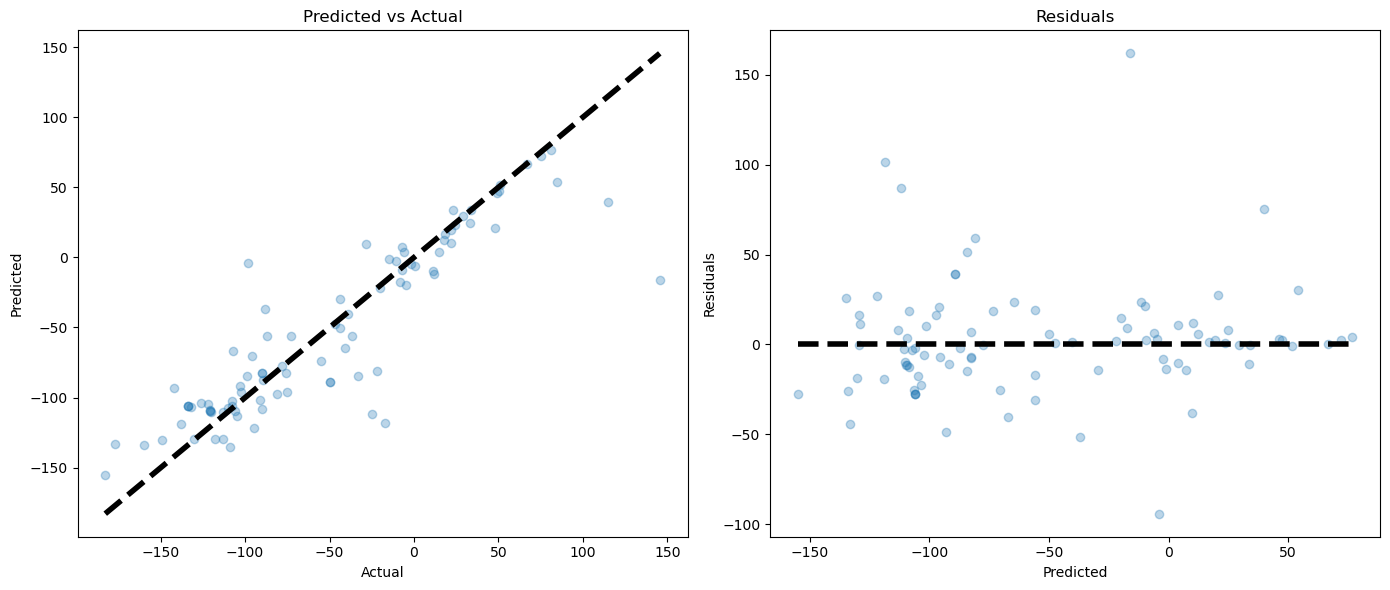

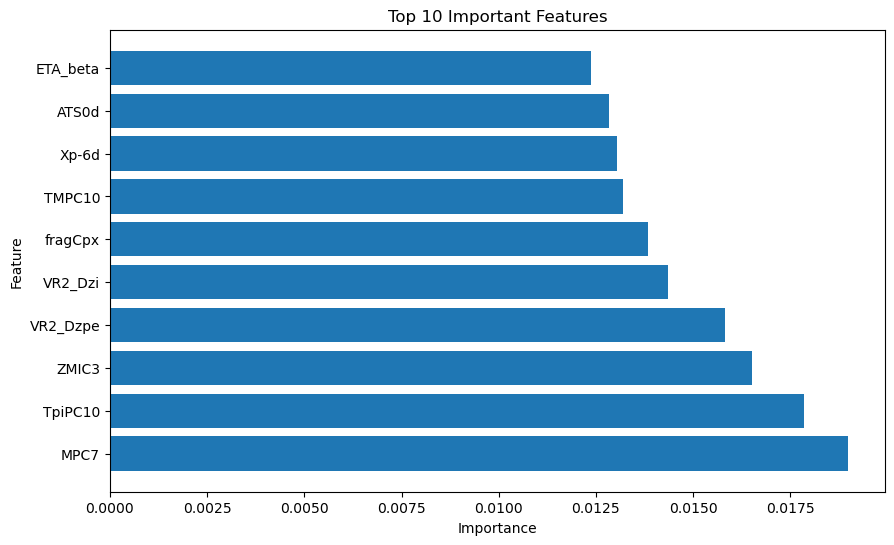

In [8]:
# visualize result for the best random forest model

# Separating the features and the target variable
X = selected_rows.drop(columns=['smiles', 'mpC'])  # Features (descriptors)
X = X.dropna(axis='columns')
y = selected_rows['mpC']  # Target variable (Melting Point)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the model with the best parameters
rf_best = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500)

# Fit the model
rf_best.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning RandomForestRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')

# Plotting Residuals
residuals = y_test - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.3)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances = rf_best.feature_importances_
features = np.array(X_train.columns)
df_feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
df_sorted = df_feature_importances.sort_values('importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['feature'], df_sorted['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.show()


In [170]:
"""
# Define the model
gb = GradientBoostingRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],  
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
}

# Setup the grid search
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_gb = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_gb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")
""""

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
After tuning - MSE: 1116.87, R2: 0.80


In [3]:
# Separating the features and the target variable
X = selected_rows.drop(columns=['smiles', 'mpC'])  # Features (descriptors)
X = X.dropna(axis='columns')
y = selected_rows['mpC']  # Target variable (Melting Point)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Creating the model with the best parameters
gb_best = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200)

# Fitting the model
gb_best.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_best.predict(X_test)

mse = mean_squared_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)
print(f"After tuning GradientBoostingRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_gb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting - Predicted vs Actual')

# Plotting Residuals
residuals_gb = y_test - y_pred_gb

plt.subplot(1, 2, 2)
plt.scatter(y_pred_gb, residuals_gb, alpha=0.3)
plt.plot([y_pred_gb.min(), y_pred_gb.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Gradient Boosting - Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances_gb = gb_best.feature_importances_
df_feature_importances_gb = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances_gb})
df_sorted_gb = df_feature_importances_gb.sort_values('importance', ascending=False).head(10)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(df_sorted_gb['feature'], df_sorted_gb['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting - Top 10 Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

NameError: name 'selected_rows' is not defined

In [7]:
# Define and fit the model
basic_lgbm = LGBMRegressor(random_state=42)
basic_lgbm.fit(X_train, y_train)

# Predictions and evaluation
y_pred_basic = basic_lgbm.predict(X_test)
mse_basic = mean_squared_error(y_test, y_pred_basic)
r2_basic = r2_score(y_test, y_pred_basic)
print(f"Basic LGBM - MSE: {mse_basic:.2f}, R2: {r2_basic:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23795
[LightGBM] [Info] Number of data points in the train set: 211, number of used features: 474
[LightGBM] [Info] Start training from score -46.927488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [1]:
"""
# Define the model
lgbm = LGBMRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [-1, 3],
    'num_leaves': [5,10],
    'min_child_samples': [20, 50]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_lgbm = grid_search.best_estimator_

# Predictions and evaluation
y_pred_lgbm = best_lgbm.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"After tuning - MSE: {mse_lgbm:.2f}, R2: {r2_lgbm:.2f}")
"""

NameError: name 'LGBMRegressor' is not defined

In [ ]:
# Creating the model with the best parameters from the tuning (GRIDSEARCH RUN IN COLAB)
best_lgbm = LGBMRegressor(learning_rate=0.05, max_depth=3, min_child_samples=20, n_estimators=200, num_leaves=15)

# Fitting the model
best_lgbm.fit(X_train, y_train)

# Making predictions
y_pred = best_lgbm.predict(X_test)

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')

# Plotting Residuals
residuals = y_test - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.3)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances = best_lgbm.feature_importances_
features = np.array(X_train.columns)
df_feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
df_sorted = df_feature_importances.sort_values('importance', ascending=False).head(10)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['feature'], df_sorted['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()
